In [143]:
from transformers import PreTrainedModel, AutoModelForQuestionAnswering, AutoTokenizer, AutoFeatureExtractor, LayoutLMv3Model, LayoutLMv3Config, BartModel
import os
from PIL import Image, ImageOps
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

from timm.models.layers import to_2tuple

In [112]:
pretrained_model_name = "microsoft/layoutlmv3-base"
model = AutoModelForQuestionAnswering.from_pretrained(pretrained_model_name)

Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias', 'qa_outputs.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [113]:
model.layoutlmv3.patch_embed

LayoutLMv3PatchEmbeddings(
  (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
)

In [132]:
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.patch_shape = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.proj1 = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.proj2 = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.proj3 = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        # The following variables are used in detection mycheckpointer.py
        self.num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.num_patches_w = self.patch_shape[0]
        self.num_patches_h = self.patch_shape[1]

    def forward(self, x, position_embedding=None):
        print(len(x[0]))
        x = self.proj(x)

        if position_embedding is not None:
            # interpolate the position embedding to the corresponding size
            position_embedding = position_embedding.view(1, self.patch_shape[0], self.patch_shape[1], -1).permute(0, 3, 1, 2)
            Hp, Wp = x.shape[2], x.shape[3]
            position_embedding = F.interpolate(position_embedding, size=(Hp, Wp), mode='bicubic')
            x = x + position_embedding

        x = x.flatten(2).transpose(1, 2)
        return x


In [133]:
image_post = feature_extractor(image.convert("RGB"), return_tensors="np")["pixel_values"][0].tolist()
embedder = PatchEmbed(768)
embedder(image_post)

224


AttributeError: 'PatchEmbed' object has no attribute 'proj'

In [115]:
model.layoutlmv3.patch_embed = PatchEmbed(model.config.hidden_size)

In [116]:
model.layoutlmv3.patch_embed

PatchEmbed(
  (proj1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (proj2): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
)

In [141]:
for i in model.named_modules():
    print(i[0])


layoutlmv3
layoutlmv3.embeddings
layoutlmv3.embeddings.word_embeddings
layoutlmv3.embeddings.token_type_embeddings
layoutlmv3.embeddings.LayerNorm
layoutlmv3.embeddings.dropout
layoutlmv3.embeddings.position_embeddings
layoutlmv3.embeddings.x_position_embeddings
layoutlmv3.embeddings.y_position_embeddings
layoutlmv3.embeddings.h_position_embeddings
layoutlmv3.embeddings.w_position_embeddings
layoutlmv3.patch_embed
layoutlmv3.patch_embed.proj1
layoutlmv3.patch_embed.proj2
layoutlmv3.pos_drop
layoutlmv3.LayerNorm
layoutlmv3.dropout
layoutlmv3.norm
layoutlmv3.encoder
layoutlmv3.encoder.layer
layoutlmv3.encoder.layer.0
layoutlmv3.encoder.layer.0.attention
layoutlmv3.encoder.layer.0.attention.self
layoutlmv3.encoder.layer.0.attention.self.query
layoutlmv3.encoder.layer.0.attention.self.key
layoutlmv3.encoder.layer.0.attention.self.value
layoutlmv3.encoder.layer.0.attention.self.dropout
layoutlmv3.encoder.layer.0.attention.output
layoutlmv3.encoder.layer.0.attention.output.dense
layoutlmv3.

In [138]:
a = model.state_dict()
a[""]

OrderedDict([('layoutlmv3.cls_token',
              tensor([[[ 2.6100e-02,  1.6481e-02,  4.2348e-03, -1.4010e-02,  5.7828e-02,
                        -4.1308e-02,  2.5909e-02,  1.9742e-02,  6.8271e-03,  1.9542e-02,
                        -1.2167e-02, -6.1761e-02,  2.5453e-04, -3.8880e-02, -3.3446e-02,
                         1.4634e-02, -3.2078e-02, -2.0572e-03,  2.3206e-02,  3.7282e-03,
                         1.4419e-03,  4.2170e-03, -2.1823e-02,  1.4557e-02, -1.8713e-02,
                        -1.5180e-02, -1.1981e-02, -5.1928e-03, -8.5169e-03, -1.4736e-02,
                        -4.2168e-03, -1.9136e-02, -5.6153e-03,  1.3629e-02, -1.8286e-02,
                        -3.2051e-03,  3.3204e-02, -2.4785e-04,  6.7873e-03,  1.1278e-02,
                        -9.8293e-03,  2.5299e-02, -1.1900e-02, -5.3601e-03,  3.3671e-03,
                        -3.9943e-03, -1.2792e-02, -8.7186e-02, -2.1766e-03,  1.7465e-02,
                        -5.6653e-02,  4.1537e-02, -2.0982e-02, -1.2635e-

In [135]:
model.layoutlmv3.config

LayoutLMv3Config {
  "_name_or_path": "microsoft/layoutlmv3-base",
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "coordinate_size": 128,
  "eos_token_id": 2,
  "has_relative_attention_bias": true,
  "has_spatial_attention_bias": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "input_size": 224,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_2d_position_embeddings": 1024,
  "max_position_embeddings": 514,
  "max_rel_2d_pos": 256,
  "max_rel_pos": 128,
  "model_type": "layoutlmv3",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "patch_size": 16,
  "rel_2d_pos_bins": 64,
  "rel_pos_bins": 32,
  "second_input_size": 112,
  "shape_size": 128,
  "text_embed": true,
  "torch_dtype": "float32",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "visual_embed": true,
  "vocab_size": 50265
}

#### Feature extractor

In [131]:
feature_extractor = AutoFeatureExtractor.from_pretrained(pretrained_model_name, apply_ocr=False, size=224)

In [26]:
feature_extractor

LayoutLMv3FeatureExtractor {
  "apply_ocr": false,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "LayoutLMv3FeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "ocr_lang": null,
  "resample": 2,
  "size": 400,
  "tesseract_config": ""
}

In [32]:
def process_image(image):
    image_post = feature_extractor(image.convert("RGB"), return_tensors="np")["pixel_values"][0]
    img = Image.new("RGB", (224, 224))
    values = (((image_post*0.5) + 0.5)*255).astype(np.uint32)
    r = values[0].flatten().tolist()
    g = values[1].flatten().tolist()
    b = values[2].flatten().tolist()
    img.putdata(list(zip(r, g, b)))
    
    return img

In [93]:
# InfographicVQA
split = "train"
folder = os.listdir(f"../data/infographicvqa/{split}/infographicVQA_{split}_v1.0_images")
image = Image.open(f"../data/infographicvqa/{split}/infographicVQA_{split}_v1.0_images/{random.sample(folder, 1)[0]}")

In [118]:
# DocVQA
folder = os.listdir(f"../data/docvqa/{'train'}/documents")
image = Image.open(f"../data/docvqa/{'train'}/documents/{random.sample(folder, 1)[0]}")

(4880, 4881)


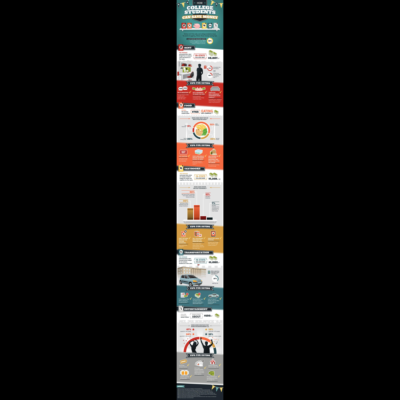

In [94]:
#TODO: add black stripes to create a squared image


size = image.size

a = int(np.floor((max(size) - min(size))/2))

# border = (left, top, right, bottom) 
border = (0, a, 0, a) if size[0] > size[1] else (a, 0, a, 0)    

color = "black"

new_image = ImageOps.expand(image, border=border, fill=color)
print(new_image.size)
process_image(new_image)

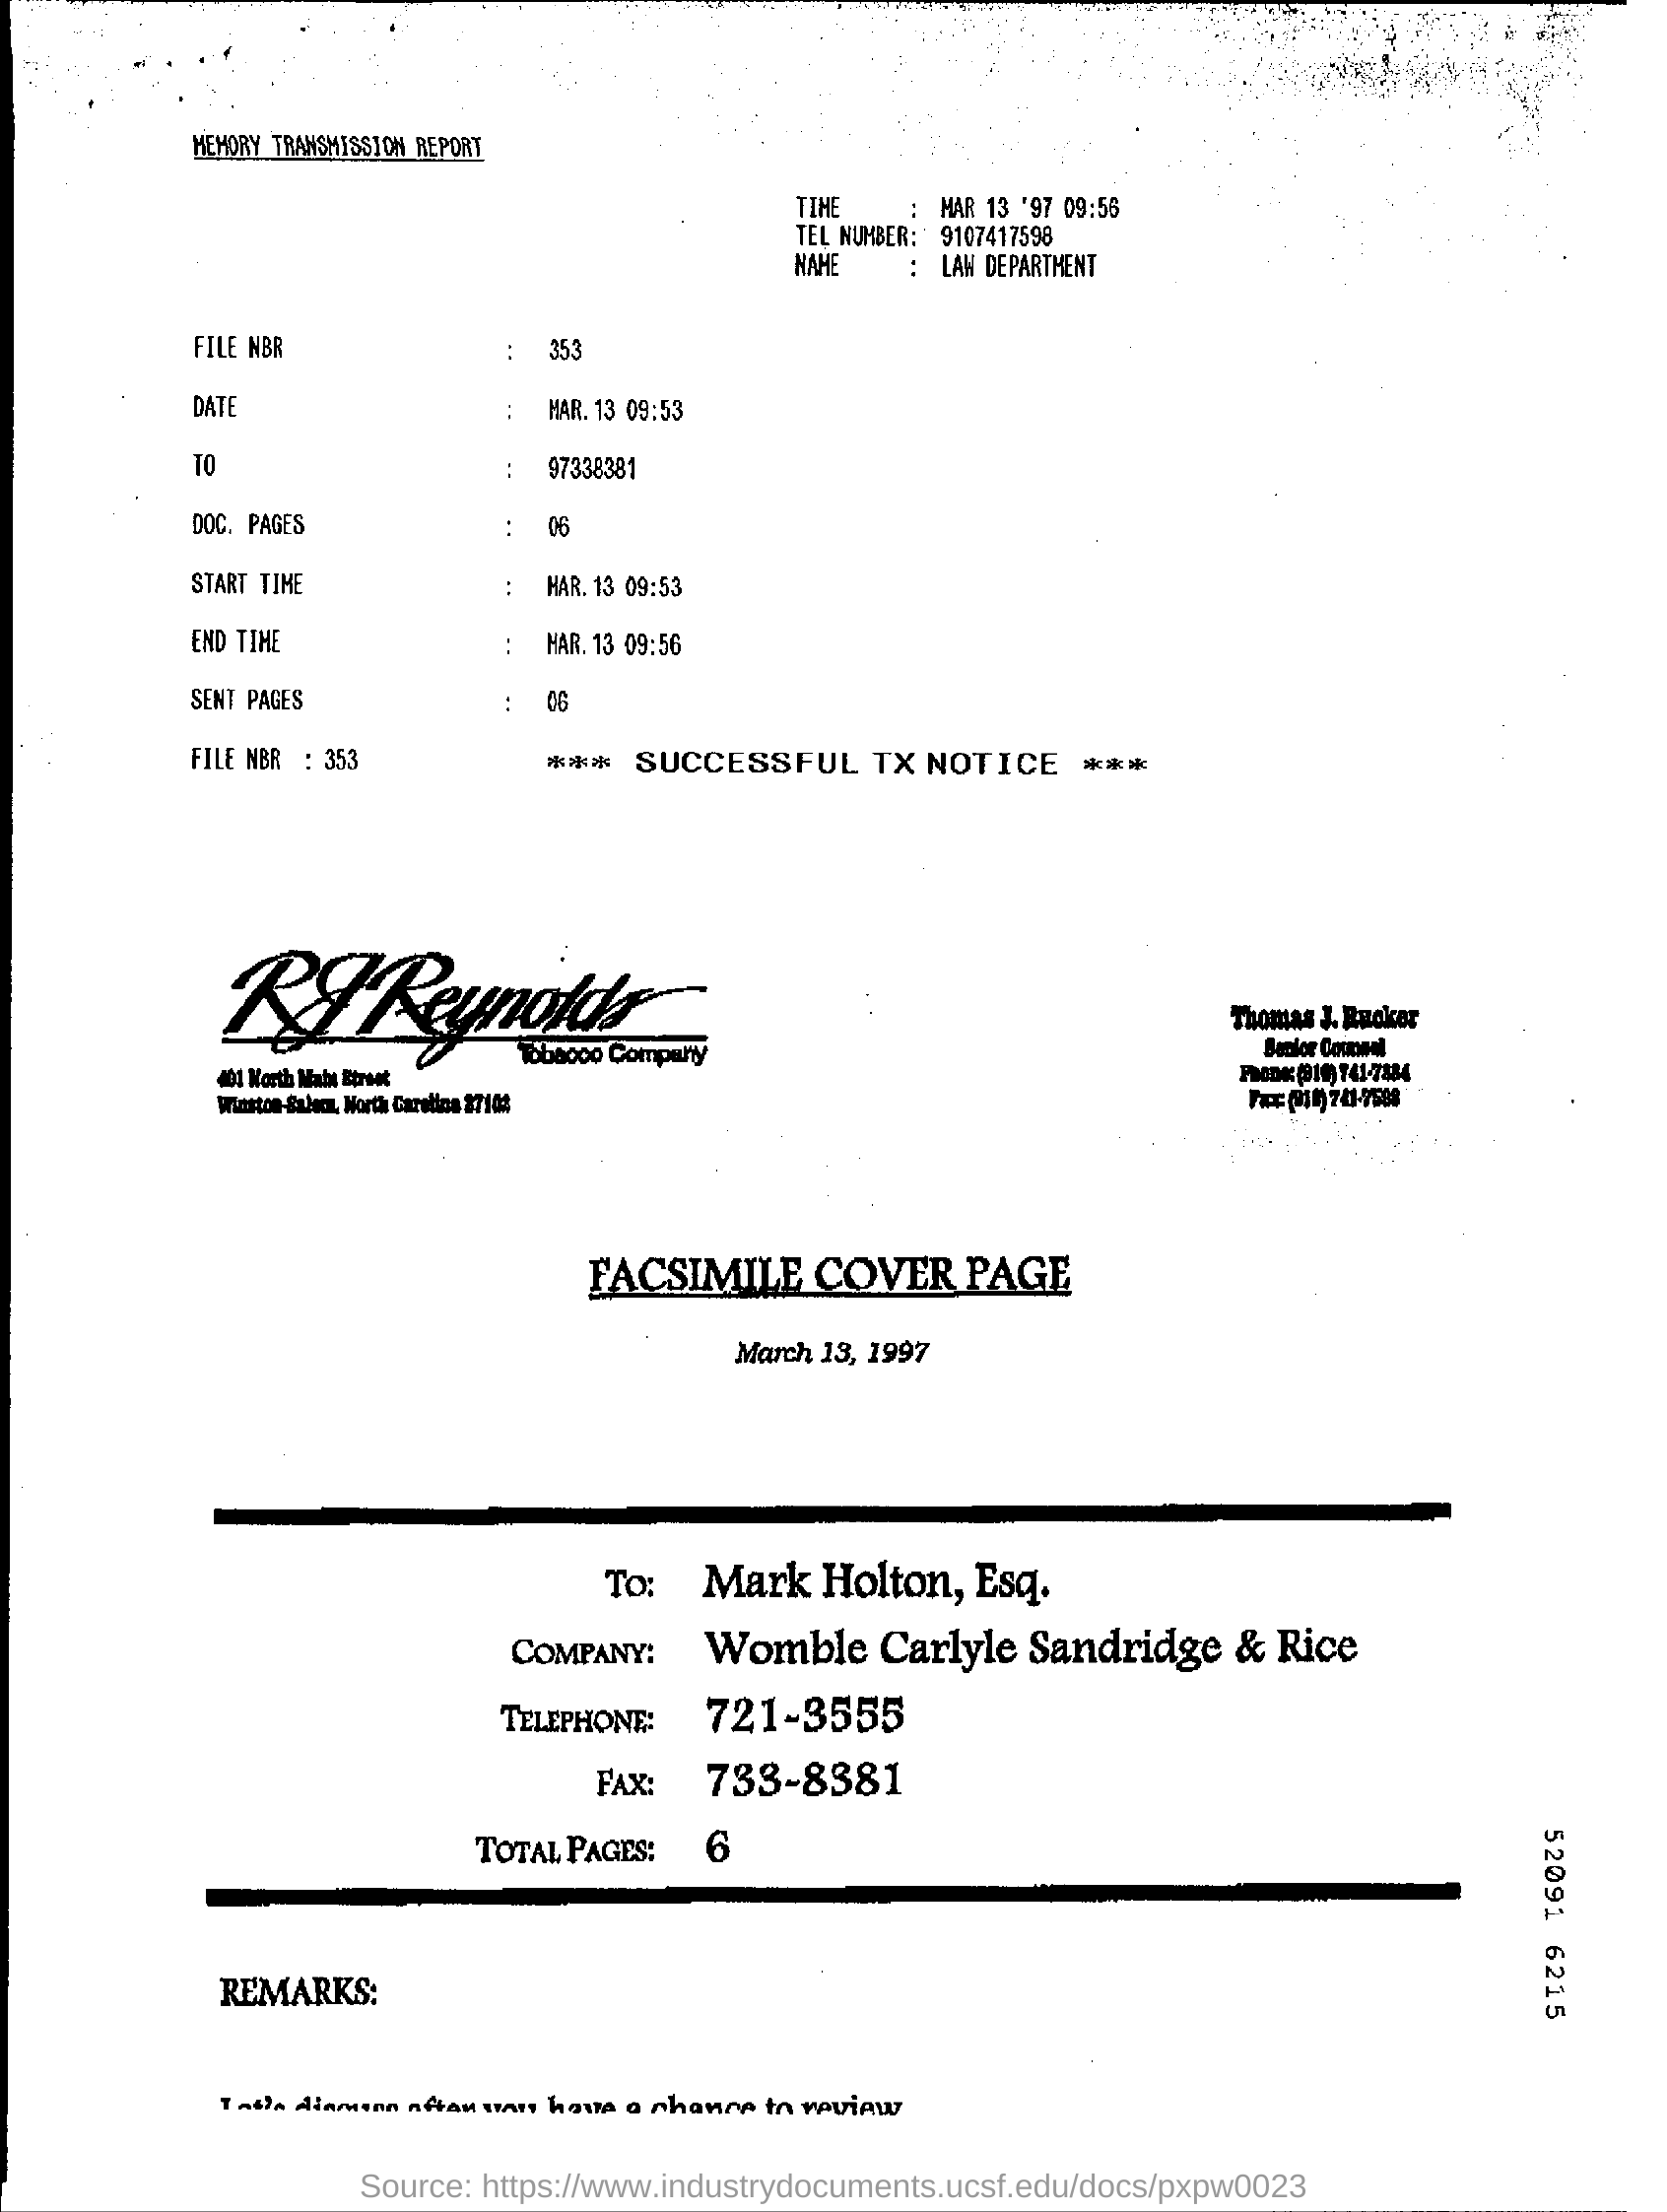

In [147]:
image.resize((200,20))


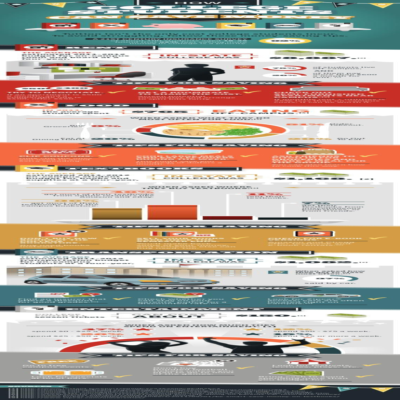

In [95]:
process_image(image)

In [151]:
checkpoint = torch.load(f"../model_files/docvqa_msr_ocr_finetune_base_50epoch_smaller_lr/state_dict.pth", map_location="cpu")

In [152]:
checkpoint.keys()

odict_keys(['layoutlmv3.cls_token', 'layoutlmv3.pos_embed', 'layoutlmv3.embeddings.position_ids', 'layoutlmv3.embeddings.word_embeddings.weight', 'layoutlmv3.embeddings.token_type_embeddings.weight', 'layoutlmv3.embeddings.LayerNorm.weight', 'layoutlmv3.embeddings.LayerNorm.bias', 'layoutlmv3.embeddings.position_embeddings.weight', 'layoutlmv3.embeddings.x_position_embeddings.weight', 'layoutlmv3.embeddings.y_position_embeddings.weight', 'layoutlmv3.embeddings.h_position_embeddings.weight', 'layoutlmv3.embeddings.w_position_embeddings.weight', 'layoutlmv3.patch_embed.proj.weight', 'layoutlmv3.patch_embed.proj.bias', 'layoutlmv3.LayerNorm.weight', 'layoutlmv3.LayerNorm.bias', 'layoutlmv3.norm.weight', 'layoutlmv3.norm.bias', 'layoutlmv3.encoder.layer.0.attention.self.query.weight', 'layoutlmv3.encoder.layer.0.attention.self.query.bias', 'layoutlmv3.encoder.layer.0.attention.self.key.weight', 'layoutlmv3.encoder.layer.0.attention.self.key.bias', 'layoutlmv3.encoder.layer.0.attention.self